## Import libraries

In [54]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn,optim
from torch.utils.data import TensorDataset,DataLoader,ConcatDataset
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score
from sklearn.preprocessing import LabelBinarizer

## Download Dataset

In [55]:
training_set = datasets.MNIST('/content',train=True,download=True)
testing_set = datasets.MNIST('/content',train=False,download=True)

## Prepare the data

In [56]:
invert = lambda image : 255 - image # function to invert the image
normalize = lambda image : image / 255 # function for bringing pixel values in range [0,1]

# function to prepare the dataset for a given digit
def prepare_training_data(dataset,digit):
    dataset_images = dataset.data.numpy() # convert the dataset into numpy array
    dataset_labels = dataset.targets.numpy() # convert the labels into numpy array
    
    indices = np.asarray(np.where(dataset_labels == digit)) # indices of occurrence of digit as label
    indices = indices.flatten()
    num_of_examples = len(indices) # total number of examples of this digit
    dataset_images_positive = dataset_images[indices] # images consisting of positive class
    dataset_labels_positive = np.full(shape=(num_of_examples,2),fill_value=[1,0],dtype=np.float32)
    dataset_images_negative = invert(dataset_images_positive) # images consisting of negative class
    dataset_labels_negative = np.full(shape=(num_of_examples,2),fill_value=[0,1],dtype=np.float32) 
    # concatenate the negative and positive datasets
    modified_dataset_images = np.concatenate((dataset_images_positive,dataset_images_negative))
    modified_dataset_labels = np.concatenate((dataset_labels_positive,dataset_labels_negative))
    tensor_x = torch.Tensor(modified_dataset_images)
    tensor_y = torch.Tensor(modified_dataset_labels)
    new_dataset = TensorDataset(tensor_x,tensor_y)
    return new_dataset

def concat_datasets(dataset1,dataset2,digit):
    dataset1_images = dataset1.data.numpy() # convert the dataset into numpy array
    dataset1_labels = dataset1.targets.numpy() # convert the labels into numpy array
    dataset2_images = dataset2.data.numpy()
    dataset2_labels = dataset2.targets.numpy()
    # join the two datasets
    joined_dataset_images = np.concatenate((dataset1_images,dataset2_images))
    joined_dataset_labels = np.concatenate((dataset1_labels,dataset2_labels))
    indices = np.asarray(np.where(joined_dataset_labels == digit)) # indices of occurrence of digit as label
    indices = indices.flatten()
    num_of_examples = len(indices) # total number of examples of this digit
    dataset_images_positive = joined_dataset_images[indices] # images consisting of positive class
    dataset_labels_positive = np.full(shape=(num_of_examples,2),fill_value=[1,0],dtype=np.float32)
    dataset_images_negative = np.delete(joined_dataset_images,indices,0) # images consisting of negative class
    total = joined_dataset_images.shape[0]
    dataset_labels_negative = np.full(shape=(total - num_of_examples,2),fill_value=[0,1],dtype=np.float32) 

    modified_dataset_images = np.concatenate((dataset_images_positive,dataset_images_negative))
    modified_dataset_labels = np.concatenate((dataset_labels_positive,dataset_labels_negative))
#     modified_dataset_images = normalize(modified_dataset_images)
    tensor_x = torch.Tensor(modified_dataset_images)
    tensor_y = torch.Tensor(modified_dataset_labels)
    new_dataset = TensorDataset(tensor_x,tensor_y)
    return new_dataset

train_digit_set = prepare_training_data(training_set,0) # fetch the training set for a digit
test_digit_set = concat_datasets(training_set,testing_set,0)
train_loader = DataLoader(train_digit_set,batch_size=64,shuffle=True)
test_loader = DataLoader(test_digit_set,batch_size=64,shuffle=True) # take original testing set of 10 digits

### Plotting some data

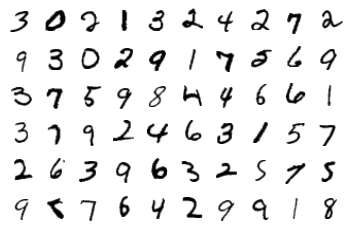

In [57]:
dataiter = iter(test_loader)
images,labels = dataiter.next()
figure = plt.figure()
# print(labels)
num_of_images = 60
for index in range(1,num_of_images+1):
    plt.subplot(6,10,index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(),cmap='gray_r')

## Build the neural network

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=2, bias=True)
    (3): Softmax(dim=1)
  )
)

Training time in minutes = 0.07132788101832072


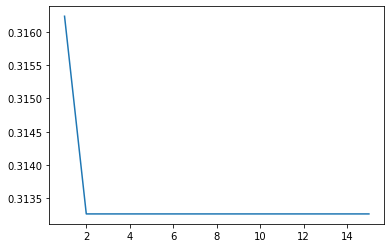

In [58]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork,self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28,10),
            nn.ReLU(),
            nn.Linear(10,2),
            nn.Softmax(dim=1)
        )
        
    def forward(self,x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

criterion = nn.CrossEntropyLoss()
print(model)
optimizer = optim.SGD(model.parameters(),lr = 1e-3,momentum=0.9)
time0 = time()
epochs = 15

def train(dataloader,model,loss_fn,optimizer):
    model.train()
    loss_vals = []
    for e in range(epochs):
        epoch_loss = []
        for batch, (images,logits) in enumerate(dataloader):
            # compute prediction error
            output = model(images)
            loss = loss_fn(output,logits)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            epoch_loss.append(loss.item())
            optimizer.step()
        loss_vals.append(sum(epoch_loss)/len(epoch_loss))
    plt.plot(np.linspace(1,epochs,epochs).astype(int),loss_vals)
    
train(train_loader,model,criterion,optimizer)
    
print(f"\nTraining time in minutes = {(time()-time0)/60}")

## Testing

In [59]:
def test(dataloader,model):
    size = len(dataloader.dataset)
    model.eval()
    correct = 0
    pred = []
    with torch.no_grad():
        for images,logits in dataloader:
            output = model(images)
            correct += (output.argmax(1) == logits.argmax(1)).type(torch.float).sum().item()
            for i in range(len(output)):
                pred.append(np.argmax(output.numpy()[i]))
    correct /= size
    print(f"Accuracy : {(100*correct):>0.1f}%")
    return pred

y_pred_train = test(train_loader,model)
y_pred_test = test(test_loader,model)
lb = LabelBinarizer()
lb.fit([0,1])
binarized_labels = lb.transform(y_pred_test)
binarized_labels = np.hstack((binarized_labels,1-binarized_labels))
# print(binarized_labels)


Accuracy : 100.0%
Accuracy : 10.0%
